In [27]:
import numpy as np
import scipy as sp
import pandas as pd
import pysindy as ps
import matplotlib.pyplot as plt
import warnings
from imp import reload

from utilities import *
from bootstrapping import *
from optimizers import *
from weak_forms import *

In [2]:
def run_search(Theta, X_dot, var, 
               n_bootstraps = 100, n_features_to_drop = 1, n_max_features = 5,
               feature_names_list = [" "], print_hierarchy = 0):
    """
    Performs a searcg of the ALASSO solution (regularization) path, indentifies supports and fits them with OLS, returning the optimal model
    Can bootstrap data (n_bootstraps) and features (n_features_to_drop) randomly in the feature selection (support finding) process. 
    Only keeps supports with a number of features below n_max_features 
    IN: Theta [n_points, n_features], X_dot [n_points], supports [n_supports, n_features]

    """
    coefs = np.zeros((Theta.shape[1], 100, n_bootstraps))
    sup = np.zeros_like(coefs[:,:,0])
    supports = []
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        for i in range(n_bootstraps):
            if n_bootstraps != 1:
                Theta_new, X_dot_new, inds = bootstrapping(Theta, X_dot, n_features_to_drop = n_features_to_drop)
            else:
                Theta_new, X_dot_new, inds = Theta, X_dot, np.arange(Theta.shape[1])
            alphas, coefs[inds, :, i] = ALASSO_path(Theta_new, X_dot_new[:,var].reshape(-1,1),)
            supports += identify_unique_supports(coefs[:,:,i], n_max_features = n_max_features)
            sup += np.abs(coefs[:,:,i]) > 0
        
    supports = remove_duplicates(supports)
    coef_list, score, n_terms = fit_supports(Theta, X_dot[:,var], supports)
    opt_coefs, index_min = find_optimal_support(coef_list, score, n_terms)
    print_hierarchy_f(print_hierarchy, coef_list, n_terms, score, feature_names_list)
    return opt_coefs, score[index_min]

## 1. Test differential algorithm in Lotka-Volterra

In [3]:
def generate_Theta(X):
    Theta = np.vstack((np.ones_like(X[:,0]),
                    X[:,0], X[:,1], X[:,2], 
                    X[:,0]*X[:,0], X[:,1]*X[:,1], X[:,1]*X[:,2],
                    X[:,0]*X[:,1], X[:,0]*X[:,2], X[:,1]*X[:,2])).T
    return Theta

X, t = generate_data(10, 10/0.002, "lorenz")
X_dot = ps.SmoothedFiniteDifference()(X, t)
Theta = generate_Theta(X)

feature_name_list = ["1", "x", "y", "z", "x^2", "y^2", "z^2", "x y", "x z", "y z"]
var_list = ["x", "y", "z"]

opt_coefs = np.zeros((X.shape[1], Theta.shape[1]))

print("Denoised: Without ensembling")
for var in range(X.shape[1]):
    opt_coefs[var], score = run_search(Theta, X_dot, var,
                            n_bootstraps=1, n_features_to_drop=0,
                            feature_names_list=feature_name_list, print_hierarchy=0)
    print_model(opt_coefs[var], score, feature_name_list, var_list[var])

###################
X = add_noise(X, 0.05)
X_dot = ps.SmoothedFiniteDifference()(X, t)
Theta = generate_Theta(X)

print("\n5% Noise: Without ensembling")
for var in range(X.shape[1]):
    opt_coefs[var], score = run_search(Theta, X_dot, var,
                            n_bootstraps=1, n_features_to_drop=0,
                            feature_names_list=feature_name_list, print_hierarchy=0)
    print_model(opt_coefs[var], score, feature_name_list, var_list[var])

print("\n5% Noise: With ensembling")
for var in range(X.shape[1]):
    opt_coefs[var], score = run_search(Theta, X_dot, var,
                            n_bootstraps=50, n_features_to_drop=1,
                            feature_names_list=feature_name_list, print_hierarchy=0)
    print_model(opt_coefs[var], score, feature_name_list, var_list[var])

Denoised: Without ensembling
[1.00] x_dot = +   -10.00 x +    10.00 y 
[1.00] y_dot = +    25.54 x +    -0.95 x z 
[1.00] z_dot = +    -2.67 z +     1.00 x y 

5% Noise: Without ensembling
[-1.61] x_dot = +    -2.35 x +     5.55 y +     0.11 z^2 +    -0.20 x z 
[-0.03] y_dot = +    25.00 x +    -0.93 x z 
[0.29] z_dot = +    -2.64 z +     0.99 x y 

5% Noise: With ensembling
[-1.65] x_dot = +    -9.40 x +     9.51 y 
[-0.03] y_dot = +    25.00 x +    -0.93 x z 
[0.29] z_dot = +    -2.64 z +     0.99 x y 


## 2. Test weak form algorithm in Lotka-Volterra

In [77]:
X, t = generate_data(10, 10/0.002, "lorenz")
Theta = generate_Theta(X)
Theta_sm, X_sm = compute_weak_forms(Theta, X, t)

feature_name_list = ["1", "x", "y", "z", "x^2", "y^2", "z^2", "x y", "x z", "y z"]
var_list = ["x", "y", "z"]

opt_coefs = np.zeros((X.shape[1], Theta.shape[1]))

print("Denoised: Weak without ensembling")
for var in range(X.shape[1]):
    opt_coefs[var], score = run_search(Theta_sm, X_sm, var,
                            n_bootstraps=1, n_features_to_drop=0,
                            feature_names_list=feature_name_list, print_hierarchy=0)
    print_model(opt_coefs[var], score, feature_name_list, var_list[var])

###################
X = add_noise(X, 0.15)
Theta = generate_Theta(X)
Theta_sm, X_sm = compute_weak_forms(Theta, X, t)

print("\n15% Noise: Weak without ensembling")
for var in range(X.shape[1]):
    opt_coefs[var], score = run_search(Theta_sm, X_sm, var,
                            n_bootstraps=1, n_features_to_drop=0,
                            feature_names_list=feature_name_list, print_hierarchy=0)
    print_model(opt_coefs[var], score, feature_name_list, var_list[var])

print("\n15% Noise: Weak with ensembling")
for var in range(X.shape[1]):
    opt_coefs[var], score = run_search(Theta_sm, X_sm, var,
                            n_bootstraps=32, n_features_to_drop=1,
                            feature_names_list=feature_name_list, print_hierarchy=0)
    print_model(opt_coefs[var], score, feature_name_list, var_list[var])

Denoised: Weak without ensembling
[1.00] x_dot = +   -10.00 x +    10.00 y 
[0.65] y_dot = +    -9.50 x +     9.46 y 
[0.73] z_dot = +   -51.52 1 +     0.83 y^2 

15% Noise: Weak without ensembling
[0.49] x_dot = +    -5.95 x +     6.12 y 
[0.38] y_dot = +    -7.57 x +     7.58 y 
[0.61] z_dot = +   -52.11 1 +     0.84 y^2 

15% Noise: Weak with ensembling
[0.90] x_dot = +    -9.35 x +     9.63 y +     0.02 y^2 
[0.38] y_dot = +    -7.57 x +     7.58 y 
[0.81] z_dot = +   -60.76 1 +     0.71 x^2 


## 3. Test algorithm with underdamped oscillator

Denoised: Without ensembling
[1.00] x_dot = +     1.00 v 
[0.95] v_dot = +    -8.65 x 

5% Noise: Weak with ensembling
[1.00] x_dot = +     1.00 v 
[0.95] v_dot = +    -8.99 x 


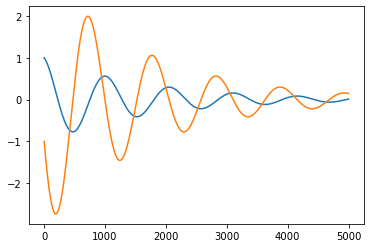

In [74]:
def generate_Theta(X):
    Theta = np.vstack((np.ones_like(X[:,0]),
                    X[:,0], X[:,1],
                    X[:,0]*X[:,0], X[:,1]*X[:,1],
                    X[:,0]*X[:,1])).T
    return Theta

feature_name_list = ["1", "x", "v", "x^2", "v^2", "x v"]
var_list = ["x", "v"]

X, t = generate_data(10, 10/0.002, "harm_osc", xi=0.1)
plt.plot(X)
X_dot = ps.SmoothedFiniteDifference()(X, t)
Theta = generate_Theta(X)
Theta_sm, X_sm = compute_weak_forms(Theta, X, t)
#Theta_sm, X_sm = windowed_generation(Theta, X, t, 5000, 100)

opt_coefs = np.zeros((X.shape[1], Theta.shape[1]))

print("Denoised: Without ensembling")
for var in range(X.shape[1]):
    opt_coefs[var], score = run_search(Theta, X_dot, var,
                            n_bootstraps=1, n_features_to_drop=0,
                            feature_names_list=feature_name_list, print_hierarchy=0)
    print_model(opt_coefs[var], score, feature_name_list, var_list[var])

print("\n5% Noise: Weak with ensembling")
for var in range(X.shape[1]):
    opt_coefs[var], score = run_search(Theta_sm, X_sm, var,
                            n_bootstraps=1, n_features_to_drop=0,
                            feature_names_list=feature_name_list, print_hierarchy=0)
    print_model(opt_coefs[var], score, feature_name_list, var_list[var])

## 4. Test algorithm with modulated Lotka-Volterra

LOW (5%) MODULATION
Denoised: Without ensembling
[0.84] ni_dot = +     0.67 ni +    -0.99 ni nn 
[0.66] nn_dot = +    -0.33 nn +     0.99 ni nn 

Denoised: With ensembling
[0.84] ni_dot = +     0.67 ni +    -0.99 ni nn 
[0.66] nn_dot = +    -0.33 nn +     0.99 ni nn 

Denoised: Weak without ensembling
[1.00] ni_dot = +     0.66 ni +    -0.99 ni nn 
[1.00] nn_dot = +    -0.34 nn +     1.00 ni nn 


HIGH (30%) MODULATION
5% noise: Without ensembling
[-5.29] ni_dot = +     0.06 1 +     0.54 ni^2 +    -0.81 ni nn 
[-11.70] nn_dot = +    -0.03 1 +     0.14 ni +    -0.28 nn +     0.69 ni nn 

5% noise: With ensembling
[-5.16] ni_dot = +     0.32 ni +     0.35 ni^2 +     0.02 nn^2 +    -0.92 ni nn 
[0.00] nn_dot = +    -0.01 1 

5% Noise: Weak without ensembling
[0.94] ni_dot = +     0.66 ni +    -0.95 ni nn 
[0.91] nn_dot = +    -0.09 1 +    -0.22 nn^2 +     1.02 ni nn 


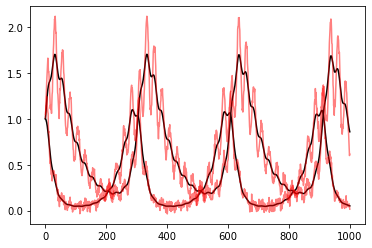

In [76]:
feature_name_list = ["1", "ni", "nn", "ni^2", "nn^2", "ni nn"]
var_list = ["ni", "nn"]

## LOW MODULATION
print("LOW (5%) MODULATION")
X, t = generate_data(50, 1000, "lotka_volterra", A = 0.05)
plt.plot(X, color="black")
X_dot = ps.SmoothedFiniteDifference()(X, t)
Theta = generate_Theta(X)
Theta_sm, X_sm = compute_weak_forms(Theta, X, t)

opt_coefs = np.zeros((X.shape[1], Theta.shape[1]))

print("Denoised: Without ensembling")
for var in range(X.shape[1]):
    opt_coefs[var], score = run_search(Theta, X_dot, var,
                            n_bootstraps=1, n_features_to_drop=0,
                            feature_names_list=feature_name_list, print_hierarchy=0)
    print_model(opt_coefs[var], score, feature_name_list, var_list[var])

print("\nDenoised: With ensembling")
for var in range(X.shape[1]):
    opt_coefs[var], score = run_search(Theta, X_dot, var,
                            n_bootstraps=32, n_features_to_drop=1,
                            feature_names_list=feature_name_list, print_hierarchy=0)
    print_model(opt_coefs[var], score, feature_name_list, var_list[var])

print("\nDenoised: Weak without ensembling")
for var in range(X.shape[1]):
    opt_coefs[var], score = run_search(Theta_sm, X_sm, var,
                            n_bootstraps=1, n_features_to_drop=0,
                            feature_names_list=feature_name_list, print_hierarchy=0)
    print_model(opt_coefs[var], score, feature_name_list, var_list[var])

## HIGH MODULATION
print("\n\nHIGH (30%) MODULATION")
X, t = generate_data(50, 1000, "lotka_volterra", A = 0.3)
X = add_noise(X, 0.05)
plt.plot(X, color="red", alpha=0.5)
X_dot = ps.SmoothedFiniteDifference()(X, t)
Theta = generate_Theta(X)
Theta_sm, X_sm = compute_weak_forms(Theta, X, t)
Theta_sm, X_sm = windowed_generation(Theta, X, t, 1000, 100)

print("5% noise: Without ensembling")
for var in range(X.shape[1]):
    opt_coefs[var], score = run_search(Theta, X_dot, var,
                            n_bootstraps=1, n_features_to_drop=0,
                            feature_names_list=feature_name_list, print_hierarchy=0)
    print_model(opt_coefs[var], score, feature_name_list, var_list[var])

print("\n5% noise: With ensembling")
for var in range(X.shape[1]):
    opt_coefs[var], score = run_search(Theta, X_dot, var,
                            n_bootstraps=100, n_features_to_drop=2,
                            feature_names_list=feature_name_list, print_hierarchy=0)
    print_model(opt_coefs[var], score, feature_name_list, var_list[var])

print("\n5% Noise: Weak without ensembling")
for var in range(X.shape[1]):
    opt_coefs[var], score = run_search(Theta_sm, X_sm, var,
                            n_bootstraps=1, n_features_to_drop=0,
                            feature_names_list=feature_name_list, print_hierarchy=0)
    print_model(opt_coefs[var], score, feature_name_list, var_list[var])